/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


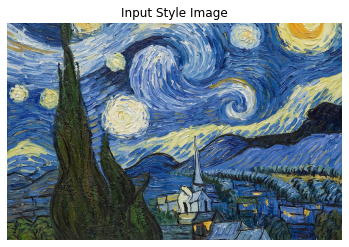

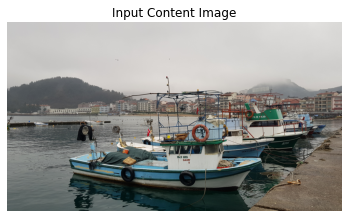

Text(0.5, 1.0, 'Total Loss vs iteration')

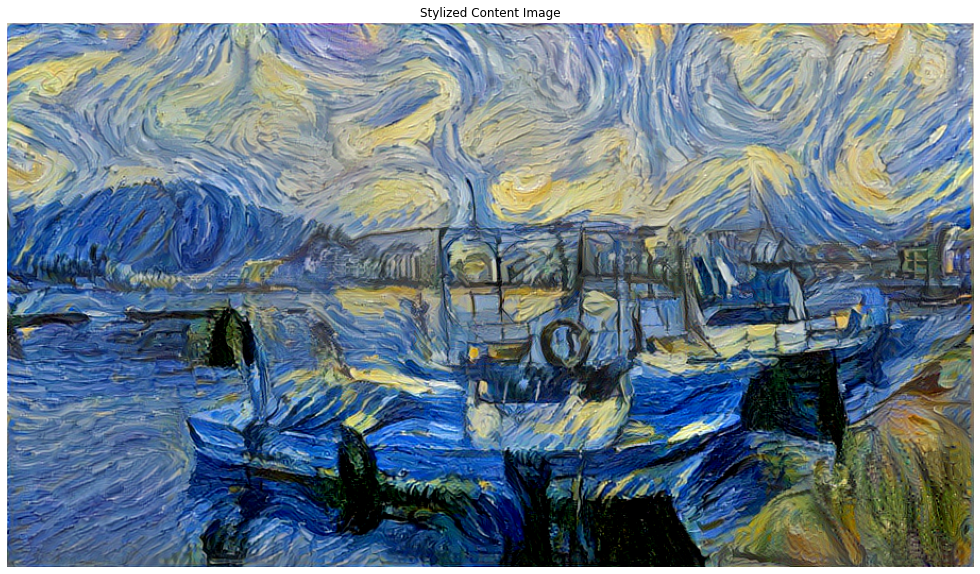

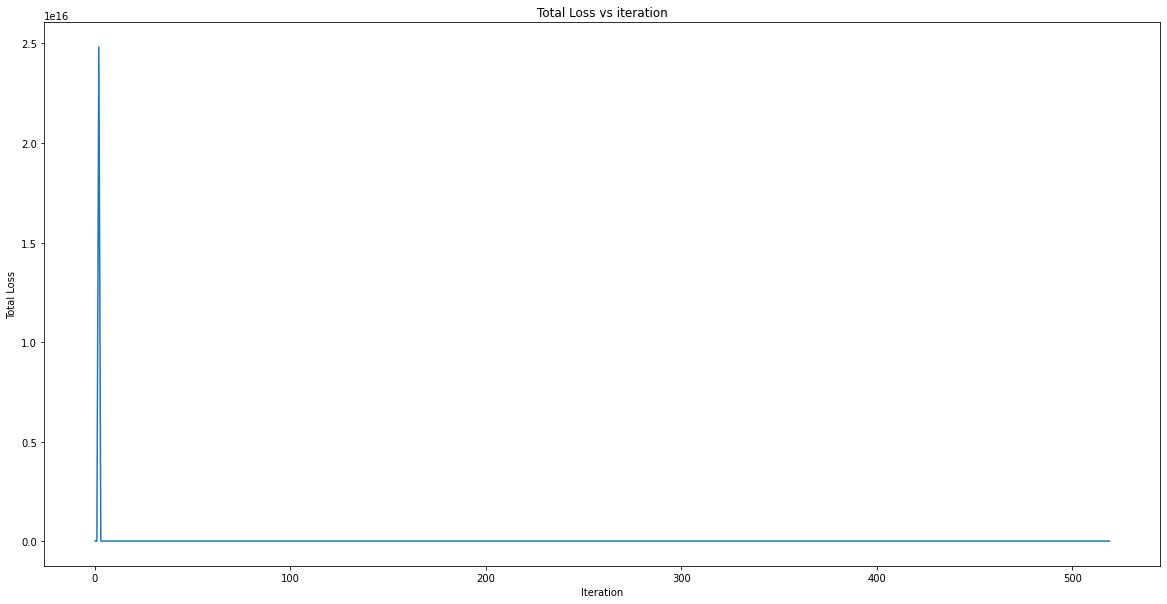

In [ ]:
import torchvision
from torchvision import transforms
 
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
 
import matplotlib.pyplot as plt
from PIL import Image

#Getting style image, content image and image size inputs
image_size = 512 #this size should be at least 299 according to ImageNet
img_name_style = "/content/train/style_starry_night.jpg"
img_name_content =  "/content/train/content_amasrasahil.jpg"

#VGG CLASS DEFINITION
class VGG(nn.Module):
  # Constructor for VGG model
  def __init__(self):
    super(VGG, self).__init__()
 
    #CNN Layers
    self.conv1_1 = nn.Conv2d(3, 64, 3, padding = 1)
    self.conv1_2 = nn.Conv2d(64, 64, 3, padding = 1)
    self.conv2_1 = nn.Conv2d(64, 128, 3, padding = 1)
    self.conv2_2 = nn.Conv2d(128, 128, 3, padding = 1)
    self.conv3_1 = nn.Conv2d(128, 256, 3, padding = 1)
    self.conv3_2 = nn.Conv2d(256, 256, 3, padding = 1)
    self.conv3_3 = nn.Conv2d(256, 256, 3, padding = 1)
    self.conv3_4 = nn.Conv2d(256, 256, 3, padding = 1)
    self.conv4_1 = nn.Conv2d(256, 512, 3, padding = 1)
    self.conv4_2 = nn.Conv2d(512, 512, 3, padding = 1)
    self.conv4_3 = nn.Conv2d(512, 512, 3, padding = 1)
    self.conv4_4 = nn.Conv2d(512, 512, 3, padding = 1)
    self.conv5_1 = nn.Conv2d(512, 512, 3, padding = 1)
    self.conv5_2 = nn.Conv2d(512, 512, 3, padding = 1)
    self.conv5_3 = nn.Conv2d(512, 512, 3, padding = 1)
    self.conv5_4 = nn.Conv2d(512, 512, 3, padding = 1)
 
    #Average Pooling
    self.pooling1 = nn.AvgPool2d(2, stride = 2)
    self.pooling2 = nn.AvgPool2d(2, stride = 2)
    self.pooling3 = nn.AvgPool2d(2, stride = 2)
    self.pooling4 = nn.AvgPool2d(2, stride = 2)
    self.pooling5 = nn.AvgPool2d(2, stride = 2)
  
 
  def forward(self, input, keys): 
    #Connecting layers and max pooling according to VGG19 structure as given in https://miro.medium.com/max/1200/0*1iD5A-Us1lQYrTSX.jpg
    #style layers: conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
    #content layers: conv4_2
    cnn = {}
    cnn["v1_1"] = F.relu(self.conv1_1(input))
    cnn["v1_2"] = F.relu(self.conv1_2(cnn["v1_1"]))
    cnn["o1"] = self.pooling1(cnn["v1_2"])
 
    cnn["v2_1"] = F.relu(self.conv2_1(cnn["o1"]))
    cnn["v2_2"] = F.relu(self.conv2_2(cnn["v2_1"]))
    cnn["o2"] = self.pooling2(cnn["v2_2"])
 
    cnn["v3_1"] = F.relu(self.conv3_1(cnn["o2"]))
    cnn["v3_2"] = F.relu(self.conv3_2(cnn["v3_1"]))
    cnn["v3_3"] = F.relu(self.conv3_3(cnn["v3_2"]))
    cnn["v3_4"] = F.relu(self.conv3_4(cnn["v3_3"]))
    cnn["o3"] = self.pooling3(cnn["v3_4"])
     
    cnn["v4_1"] = F.relu(self.conv4_1(cnn["o3"]))
    cnn["v4_2"] = F.relu(self.conv4_2(cnn["v4_1"]))
    cnn["v4_3"] = F.relu(self.conv4_3(cnn["v4_2"]))
    cnn["v4_4"] = F.relu(self.conv4_4(cnn["v4_3"]))
    cnn["o4"] = self.pooling4(cnn["v4_4"])
 
    cnn["v5_1"] = F.relu(self.conv5_1(cnn["o4"]))
    cnn["v5_2"] = F.relu(self.conv5_2(cnn["v5_1"]))
    cnn["v5_3"] = F.relu(self.conv5_3(cnn["v5_2"]))
    cnn["v5_4"] = F.relu(self.conv5_4(cnn["v5_3"]))
    cnn["o5"] = self.pooling5(cnn["v5_4"])
        
    #Returns specified feature maps
    return [cnn[key] for key in keys]
 
# Computes the content loss
class LossContent(nn.Module):
    def forward(self, features, content):
        out = nn.MSELoss()(features, content)
        return out
        
#Gram Matrix class definition
class GramMatrix(nn.Module):
    def forward(self, features):
        b, k, w, h = features.size()  
        F = features.view(b , k, h * w)
        G = torch.bmm(F, F.transpose(1, 2))
        G.div_(h*w)
        return G
 
#Computes the style loss
class LossStyle(nn.Module):
    def forward(self, features, style):
        out = nn.MSELoss()(GramMatrix()(features), style)
        return out
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model = VGG()
model.load_state_dict(torch.load('/content/vgg_conv_weights.pth'))            
for param in model.parameters():
    if param.requires_grad != False:
      param.requires_grad = False
if torch.cuda.is_available():
    model.cuda()
 
 
#Preprocessing
preprocessing = transforms.Compose([transforms.Scale(image_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])]), 
                           transforms.Normalize(mean = [0.406, 0.456, 0.485], std =  [1, 1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),])
 
#Postprocessing
postprocessing = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                            transforms.Normalize(mean = [-0.406, -0.456, -0.485], std =  [1,1,1]),
                            transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),])
    
unloader = transforms.ToPILImage() # Converting back to PIL Image

#Clips negative pixel values
def clipper(tensor):
    temp = postprocessing(tensor)
    temp[temp>1] = 1
    temp[temp<0] = 0
    return unloader(temp)
 
style_image = Image.open(img_name_style)
content_image = Image.open(img_name_content)
 
#Checking if the desired images are given

plt.axis('off')
plt.imshow(style_image)
plt.title('Input Style Image')
plt.show()
plt.axis('off')
plt.imshow(content_image)
plt.title('Input Content Image')
plt.show()
 
#images = [unloader(style_image.squeeze(0)), unloader(content_image.squeeze(0))]
 
# Creating tensor variables of the images
tensor_style_img = Variable((preprocessing(style_image)).unsqueeze(0)).cuda()
tensor_cont_img = Variable((preprocessing(content_image)).unsqueeze(0)).cuda()
optimized_img = Variable(tensor_cont_img.clone(), requires_grad = True)
 
 
#Specifying style and content layers
loss_layers = ["v1_1", "v2_1", "v3_1", "v4_1", "v5_1", "v4_2"]
style_layers = loss_layers[0:5]
content_layers = [loss_layers[5]]
 
#Utilizing CUDA for loss functions
loss_style = LossStyle().cuda()
loss_content = LossContent().cuda()
    
#Loss weights
style_weights = [1/5] * 5
content_weight = 1
 
style_feature_maps = [GramMatrix()(output).detach() for output in model(tensor_style_img, style_layers)]
content_feature_map = [output.detach() for output in model(tensor_cont_img, content_layers)] 
 
#Training
ITERATION = 500
optimizer = optim.LBFGS([optimized_img])
iter = [0]
loss = []
stLoss = []
conLoss = []

while iter[0] <= ITERATION:
  
    def training():
        optimizer.zero_grad() #setting gradients 0 at the beginning
        
        layers_out = model(optimized_img, loss_layers)
        
        #Loss calculation
        style_losses = torch.tensor(10^3)*[style_weights[i] * loss_style(layers_out[i], style_feature_maps[i]) for i in range(5)]
        content_losses = [content_weight * loss_content(layers_out[5], content_feature_map[0])]
        total_loss = sum(style_losses + content_losses)
        
        #Backward Propagation
        total_loss.backward()
        
        loss.append(total_loss)
        stLoss.append(sum(style_losses))
        conLoss.append(content_losses)
        iter[0] += 1
        
        return total_loss
    
    optimizer.step(training)
    
#Displaying Results
 
out_img = clipper(optimized_img.data[0].cpu().squeeze())
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(out_img)
plt.title("Stylized Content Image")
plt.figure(figsize=(20,10))
plt.plot(loss)
plt.xlabel("Iteration")
plt.ylabel("Total Loss")
plt.title("Total Loss vs iteration")

